In [2]:
#We will make a basic CNN model to classify CIFAR-100#
#We will use Keras from Tensorflow to build the model#

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt
import datetime

#show the tensorflow version
print(tf.__version__)


2.10.1


In [3]:
#Test if have GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 312748461048338632
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5713326080
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10250137994035873141
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
#load the CIFAR-100 dataset & split into train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#Normalize pixel values from 1-255 to 0-1
x_train, x_test = x_train / 255.0, x_test / 255.0

#show the shape of the dataset
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape) 

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [6]:
#shuffle train & test data

# # Assuming x_train and y_train are your data
# indices = np.arange(x_train.shape[0])
# np.random.shuffle(indices)

# # Let's say we want to select 10000 random samples
# x_train_subset = x_train[indices[:10000]]
# y_train_subset = y_train[indices[:10000]]

In [13]:
#Build model

model = Sequential() #0

# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model.add(Flatten())
model.add(Dense(256, activation='relu'))

# Block 5
model.add(Dense(10, activation='softmax'))

# Print the model summary
model.summary()

#make four more identical models
model2 = keras.models.clone_model(model) #0.05
model3 = keras.models.clone_model(model) #0.1
model4 = keras.models.clone_model(model) #0.2
model5 = keras.models.clone_model(model) #0.5

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 128)        

In [14]:
#Compile the model wiht label smoothing
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.01),
              metrics=['accuracy'])
model3.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.1),
                metrics=['accuracy'])
model4.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.2),
                metrics=['accuracy'])
model5.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.5),
                metrics=['accuracy'])

#Train the models
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])
#one hot labels
y_train_1hot = tf.keras.utils.to_categorical(y_train, 10)
y_test_1hot = tf.keras.utils.to_categorical(y_test, 10)

history2 = model2.fit(x_train, y_train_1hot, epochs=20, validation_data=(x_test, y_test_1hot), callbacks=[tensorboard_callback])
history3 = model3.fit(x_train, y_train_1hot, epochs=20, validation_data=(x_test, y_test_1hot), callbacks=[tensorboard_callback])
history4 = model4.fit(x_train, y_train_1hot, epochs=20, validation_data=(x_test, y_test_1hot), callbacks=[tensorboard_callback])
history5 = model5.fit(x_train, y_train_1hot, epochs=20, validation_data=(x_test, y_test_1hot), callbacks=[tensorboard_callback])

#save loss & validation loss every 
train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

train_loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

train_loss4 = history4.history['loss']
val_loss4 = history4.history['val_loss']

train_loss5 = history5.history['loss']
val_loss5 = history5.history['val_loss']


Epoch 1/20
1563/1563 [==============================] - 10s 6ms/step - loss: 1.4697 - accuracy: 0.4519 - val_loss: 1.0869 - val_accuracy: 0.6130
Epoch 2/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9673 - accuracy: 0.6570 - val_loss: 0.8573 - val_accuracy: 0.6986
Epoch 3/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7626 - accuracy: 0.7333 - val_loss: 0.7572 - val_accuracy: 0.7379
Epoch 4/20
1563/1563 [==============================] - 10s 7ms/step - loss: 0.6394 - accuracy: 0.7779 - val_loss: 0.7408 - val_accuracy: 0.7494
Epoch 5/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.5430 - accuracy: 0.8109 - val_loss: 0.7875 - val_accuracy: 0.7371
Epoch 6/20
1563/1563 [==============================] - 10s 7ms/step - loss: 0.4711 - accuracy: 0.8344 - val_loss: 0.7322 - val_accuracy: 0.7648
Epoch 7/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.4088 - accuracy: 0.8557 - val_loss: 0.7773 - val_accu

c:\Users\MSI\anaconda3\envs\tf\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 10s 6ms/step - loss: 1.5596 - accuracy: 0.4254 - val_loss: 1.2202 - val_accuracy: 0.5709
Epoch 2/20
1563/1563 [==============================] - 10s 6ms/step - loss: 1.0533 - accuracy: 0.6376 - val_loss: 1.0138 - val_accuracy: 0.6566
Epoch 3/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.8476 - accuracy: 0.7196 - val_loss: 0.8484 - val_accuracy: 0.7183
Epoch 4/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7299 - accuracy: 0.7622 - val_loss: 0.8503 - val_accuracy: 0.7242
Epoch 5/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.6400 - accuracy: 0.7966 - val_loss: 0.8185 - val_accuracy: 0.7336
Epoch 6/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.5624 - accuracy: 0.8238 - val_loss: 0.7846 - val_accuracy: 0.7557
Epoch 7/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.5047 - accuracy: 0.8458 - val_loss: 0.7957 - val_accuracy: 0.754

In [ ]:
#create a folder to save all these files
import os
if not os.path.exists('cifar10_cnn'):
    os.makedirs('cifar10_cnn')


#save the trained model (Parameters) so I can use it again without training again
model.save('cifar10_cnn.h5')
model2.save('cifar10_cnn2.h5')
model3.save('cifar10_cnn3.h5')
model4.save('cifar10_cnn4.h5')
model5.save('cifar10_cnn5.h5')

#save the trained model (Weights) so I can use it again without training again
model.save_weights('cifar10_cnn_weights.h5')
model2.save_weights('cifar10_cnn2_weights.h5')
model3.save_weights('cifar10_cnn3_weights.h5')
model4.save_weights('cifar10_cnn4_weights.h5')
model5.save_weights('cifar10_cnn5_weights.h5')

#save the histories
np.save('train_loss.npy', train_loss)
np.save('val_loss.npy', val_loss)

np.save('train_loss2.npy', train_loss2)
np.save('val_loss2.npy', val_loss2)

np.save('train_loss3.npy', train_loss3)
np.save('val_loss3.npy', val_loss3)

np.save('train_loss4.npy', train_loss4)
np.save('val_loss4.npy', val_loss4)

np.save('train_loss5.npy', train_loss5)
np.save('val_loss5.npy', val_loss5)

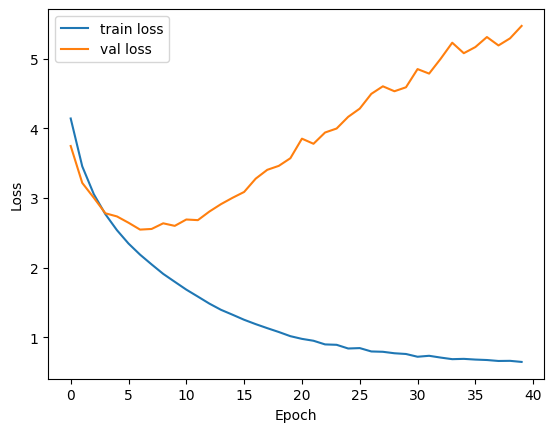

In [ ]:
#plot loss
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label = 'val loss')  

plt.xlabel('Epoch')
plt.ylabel('Loss')
#legend
plt.legend(loc='upper left')
#show plot
plt.show()


## Save the trained Model

In [ ]:
#save the trained model (Parameters) so I can use it again without training again
model.save('cifar100_cnn.h5')
#save the trained model (Weights) so I can use it again without training again
model.save_weights('cifar100_cnn_weights.h5')


NameError: name 'model' is not defined

## Load the trained Model

In [ ]:
#load the trained model (Parameters) so I can use it again without training again
#model = keras.models.load_model('cifar100_cnn.h5')

#load the trained model (Weights) so I can use it again without training again
#model.load_weights('cifar100_cnn_weights.h5')